In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
# Load your dataset
df = pd.read_csv("Data/raw_data/Transaction.csv")
df.head(5)

,Transaction ID,Customer ID,Product ID,Product Category,Purchase Amount,Purchase Date
0,1,238,45,Sensitive Skin Treatment,25,2024-03-24
1,1,238,35,Lip Care,15,2024-03-24
2,1,238,34,Lip Care,5,2024-03-24
3,1,238,4,Cleansers,20,2024-03-24
4,1,238,50,Pore Care,20,2024-03-24


In [3]:
# Prepare transaction data
basket_data = df.groupby("Transaction ID")["Product ID"].apply(list).tolist()

In [4]:
# Encode transaction list
te = TransactionEncoder()
te_ary = te.fit(basket_data).transform(basket_data)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [5]:
# Apply Apriori algorithm
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)

In [6]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

In [7]:
# Display sorted rules
rules.sort_values(by="lift", ascending=False, inplace=True)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

   antecedents consequents  support  confidence      lift
33        (39)        (40)   0.0114    0.156593  2.205541
32        (40)        (39)   0.0114    0.160563  2.205541
37        (50)        (49)   0.0116    0.156757  2.009702
36        (49)        (50)   0.0116    0.148718  2.009702
23        (49)        (33)   0.0148    0.189744  1.594484
22        (33)        (49)   0.0148    0.124370  1.594484
6         (32)        (31)   0.0212    0.188948  1.518877
7         (31)        (32)   0.0212    0.170418  1.518877
11        (31)        (49)   0.0144    0.115756  1.484047
10        (49)        (31)   0.0144    0.184615  1.484047


### Looking at the Rules at SKU Level 

In [8]:
product_df = pd.read_csv('Data/raw_data/Product.csv')
product_df.head(5)

,Product ID,Product Category,SKU,Product Price ($)
0,1,Cleansers,Gel Cleansers,20
1,2,Cleansers,Foam Cleanser,15
2,3,Cleansers,Oil Cleanser,20
3,4,Cleansers,Micellar Water,20
4,5,Cleansers,Cleansing Balm,25


In [9]:
# Step 1: Flatten antecedents and consequents
rules['antecedent_ids'] = rules['antecedents'].apply(lambda x: list(x))
rules['consequent_ids'] = rules['consequents'].apply(lambda x: list(x))

In [10]:
# Step 2: Explode lists for mapping
exploded_ante = rules[['antecedent_ids']].explode('antecedent_ids')
exploded_cons = rules[['consequent_ids']].explode('consequent_ids')

In [11]:
# Step 3: Map Product ID → SKU using a dictionary or merge
id_to_sku = product_df.set_index('Product ID')['SKU'].to_dict()
exploded_ante['SKU'] = exploded_ante['antecedent_ids'].map(id_to_sku)
exploded_cons['SKU'] = exploded_cons['consequent_ids'].map(id_to_sku)

In [12]:
# Step 4: Re-aggregate SKUs
ante_sku = exploded_ante.groupby(level=0)['SKU'].apply(list)
cons_sku = exploded_cons.groupby(level=0)['SKU'].apply(list)

In [13]:
# Step 5: Add back to rules DataFrame
rules['antecedent_skus'] = ante_sku
rules['consequent_skus'] = cons_sku

In [17]:
# Display sorted rules
rules.sort_values(by="lift", ascending=False, inplace=True)
rules[['antecedent_skus', 'consequent_skus', 'support', 'confidence', 'lift']].head(10)

,antecedent_skus,consequent_skus,support,confidence,lift
33,[Pimple Patches],[Acne Spot Treatment],0.0114,0.156593,2.205541
32,[Acne Spot Treatment],[Pimple Patches],0.0114,0.160563,2.205541
37,[Pore Strips],[Pore Minimizing Serum],0.0116,0.156757,2.009702
36,[Pore Minimizing Serum],[Pore Strips],0.0116,0.148718,2.009702
23,[Pore Minimizing Serum],[Under-Eye Patches],0.0148,0.189744,1.594484
22,[Under-Eye Patches],[Pore Minimizing Serum],0.0148,0.124370,1.594484
6,[Eye Gel],[Eye Cream],0.0212,0.188948,1.518877
7,[Eye Cream],[Eye Gel],0.0212,0.170418,1.518877
10,[Pore Minimizing Serum],[Eye Cream],0.0144,0.184615,1.484047
11,[Eye Cream],[Pore Minimizing Serum],0.0144,0.115756,1.484047


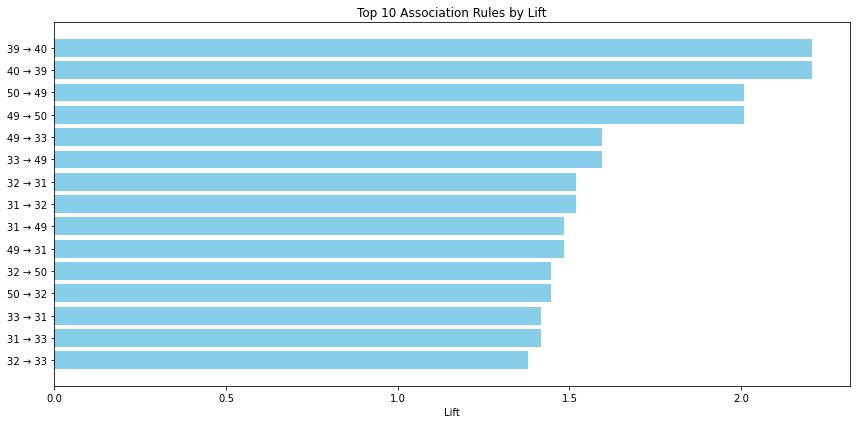

In [25]:
import matplotlib.pyplot as plt

# Sort by lift and take top 10
top_rules = rules.sort_values(by='lift', ascending=False).head(15)

# Convert frozensets to strings for plotting
top_rules['Rule'] = top_rules.apply(lambda row: f"{', '.join(map(str, row['antecedents']))} → {', '.join(map(str, row['consequents']))}", axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_rules['Rule'], top_rules['lift'], color='skyblue')
plt.xlabel('Lift')
plt.title('Top 10 Association Rules by Lift')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [28]:
import networkx as nx
import matplotlib.pyplot as plt

# Use previously created pair_counts from co-occurrence logic (fallback for mlxtend not available)
# Filter pairs that occurred together at least 5 times
significant_pairs = {pair: count for pair, count in pair_counts.items() if count >= 5}

# Build a directed graph where edge direction represents co-purchase association
G = nx.DiGraph()
for (prod1, prod2), count in significant_pairs.items():
    G.add_edge(prod1, prod2, weight=count)

# Select top 10 edges by weight for visualization
top_edges = sorted(significant_pairs.items(), key=lambda x: x[1], reverse=True)[:10]
top_graph = nx.DiGraph()
for (prod1, prod2), weight in top_edges:
    top_graph.add_edge(prod1, prod2, weight=weight)

C:\Users\natas\AppData\Local\Temp\ipykernel_14220\4237728012.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


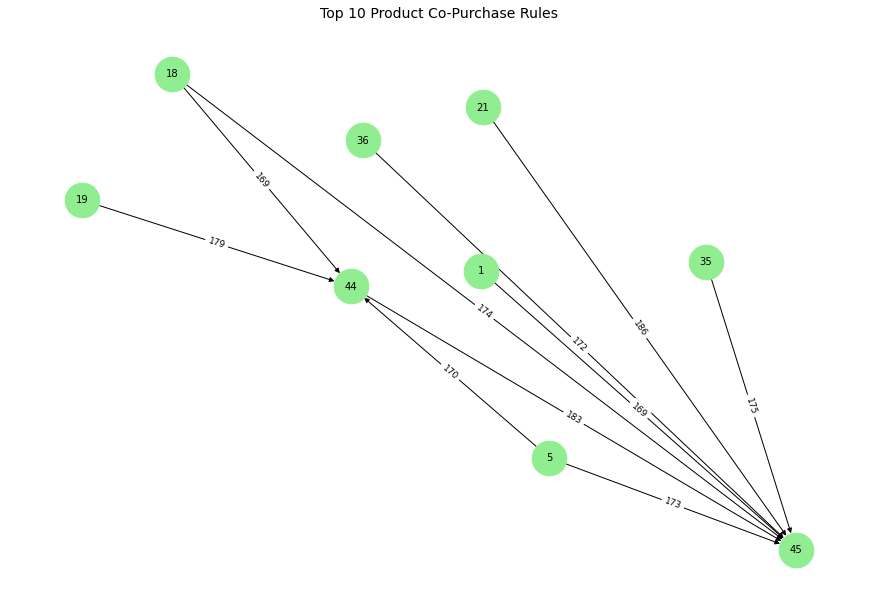

In [30]:
# Re-draw the same graph with increased spacing
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(top_graph, seed=42, k=0.7)  # Increase 'k' for more spacing

edge_labels = nx.get_edge_attributes(top_graph, 'weight')
nx.draw(top_graph, pos, with_labels=True, node_size=1200, node_color='lightgreen', font_size=10, arrows=True)
nx.draw_networkx_edge_labels(top_graph, pos, edge_labels=edge_labels, font_size=9)
plt.title("Top 10 Product Co-Purchase Rules", fontsize=14)
plt.tight_layout()
plt.show()


### Making Recommendations

In [18]:
# Step 1: Build simple co-occurrence based "rules" using product pair frequency
from itertools import combinations
from collections import defaultdict

# Create product pair frequency dictionary
pair_counts = defaultdict(int)

# Iterate through transactions and count pairs
transactions = df.groupby("Transaction ID")["Product ID"].apply(set)
for items in transactions:
    for item_pair in combinations(sorted(items), 2):
        pair_counts[item_pair] += 1

In [19]:
# Step 2: Create a mapping from each product to others often bought together
product_to_related = defaultdict(set)
for (prod1, prod2), count in pair_counts.items():
    if count >= 5:  # threshold to filter meaningful associations
        product_to_related[prod1].add(prod2)
        product_to_related[prod2].add(prod1)

In [20]:
# Step 3: Prepare customer-level product history
customer_products = df.groupby("Customer ID")["Product ID"].apply(set).reset_index()

In [21]:
# Step 4: Recommend products not already bought but often co-purchased
def recommend_from_pairs(purchased):
    recommendations = set()
    for pid in purchased:
        related = product_to_related.get(pid, set())
        recommendations.update(related)
    return list(recommendations - purchased)

customer_products["Previous Purchases"] = customer_products["Product ID"].apply(list)
customer_products["Recommended Products"] = customer_products["Product ID"].apply(recommend_from_pairs)

In [35]:
# Limit recommendations to top 5 (already sorted or just first 5 from the list)
customer_products["Recommended Products"] = customer_products["Recommended Products"].apply(lambda x: x[:5])

# Final formatting and export
recommendation_result = customer_products[["Customer ID", "Previous Purchases", "Recommended Products"]]
recommendation_result.to_csv("Data/results/Product_Recommendation_Apriori.csv", index=False)


In [34]:
recommendation_result.head(5)

,Customer ID,Previous Purchases,Recommended Products
0,1,"[1, 34, 35, 4, 5, 36, 3, 40, 2, 39, 46, 47, 48...","[32, 33, 44, 45, 49]"
1,2,"[2, 35, 3, 5, 4, 39, 40, 36, 44, 45, 46, 47, 4...","[32, 1, 34, 33, 49]"
2,3,"[1, 2, 3, 35, 4, 36, 39, 40, 5, 46, 47, 48, 18...","[32, 33, 34, 44, 45]"
3,4,"[2, 35, 4, 5, 36, 39, 40, 34, 47, 48, 20, 21]","[32, 1, 33, 3, 44]"
4,5,"[1, 34, 3, 35, 5, 4, 39, 40, 36, 44, 45, 47, 4...","[32, 33, 2, 46, 49]"


# 🧴 Product Recommendation Example — Customer ID: 1

In [ ]:
filtered_df = full_recommendation_df[full_recommendation_df['Customer ID'] == 238]
filtered_df

### 🧾 Customer Purchase History

This customer has previously purchased **18 different skincare products**, including:
- **Cleansers:** Gel Cleansers, Oil Cleanser, Micellar Water, Foam Cleanser, Cleansing Balm
- **Lip Care:** Lip Balm, Lip Scrub, Lip Mask
- **Moisturizers:** Gel Moisturizer, Cream Moisturizer, Oil-Based Moisturizer, Water-Based Moisturizer, Night Cream
- **Acne/Pore Care:** Pimple Patches, Acne Spot Treatment, Scar Treatment Cream
- **Others:** Post-Sun Care, Healing Ointments

---

### 💡 Top 5 Recommended Products

These recommendations are based on **frequent co-purchase patterns** from other customers in the dataset:

| SKU                  | Reason for Recommendation                 | Score |
|:----------------------:|:-------------------------------------------:|:--------:|
| **Soothing Creams**  | Frequently bought with moisturizers        | 18     |
| **Calming Serums**   | Often co-purchased with acne treatments    | 17     |
| **Eye Cream**        | Common with night creams & moisturizers    | 13     |
| **Eye Gel**          | Bought with eye cream & hydration routines | 13     |
| **Under-Eye Patches**| Associated with post-sun & eye care        | 13     |

---

### ✅ Recommendation Logic

- For every product this customer has bought, we analyzed which other products were frequently purchased **together** by other customers.
- Each related product received a **score based on co-occurrence frequency**.
- Products already purchased by the customer were excluded.
- The final recommendation list shows the **Top 5 most frequently co-purchased items**, sorted by relevance.

---
